## About Dataset ##

### Context
This is image data of Natural Scenes around the world.

### Content
This dataset contains around 25k images of size 150x150 distributed under 6 categories:
- `buildings` -> 0
- `forest` -> 1
- `glacier` -> 2
- `mountain` -> 3
- `sea` -> 4
- `street` -> 5

The Train, Test, and Prediction data are separated into individual zip files. There are around 14k images in Train, 3k in Test, and 7k in Prediction. This data was initially published on [DataHack](https://datahack.analyticsvidhya.com) by Intel to host an Image Classification Challenge.

Data available at: [Kaggle](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,MaxPooling2D,Dense,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image  # type: ignore
from sklearn.metrics import classification_report

In [92]:
trainpath = 'data/seg_train/seg_train'
testpath = 'data/seg_test/seg_test'
predpath = 'data/seg_pred/seg_pred'

In [93]:
IMAGE_SIZE = (288, 288)
BATCH_SIZE = 32

## Preprocessing Data ##

In [94]:
# Convert the image's paths to dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  trainpath,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.


In [95]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  testpath,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 3000 files belonging to 6 classes.


In [96]:
classes_names=train_ds.class_names
print(classes_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [97]:
def getImagePaths(path):
    image_names=[]
    for dirname, _,filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

images_paths = getImagePaths(predpath)
print('The number of Predict paths:', len(images_paths))

The number of Predict paths: 7301


In [98]:
images_paths = getImagePaths(trainpath)
print('The number of training paths:', len(images_paths))

The number of training paths: 14034


## Data Visualization ##

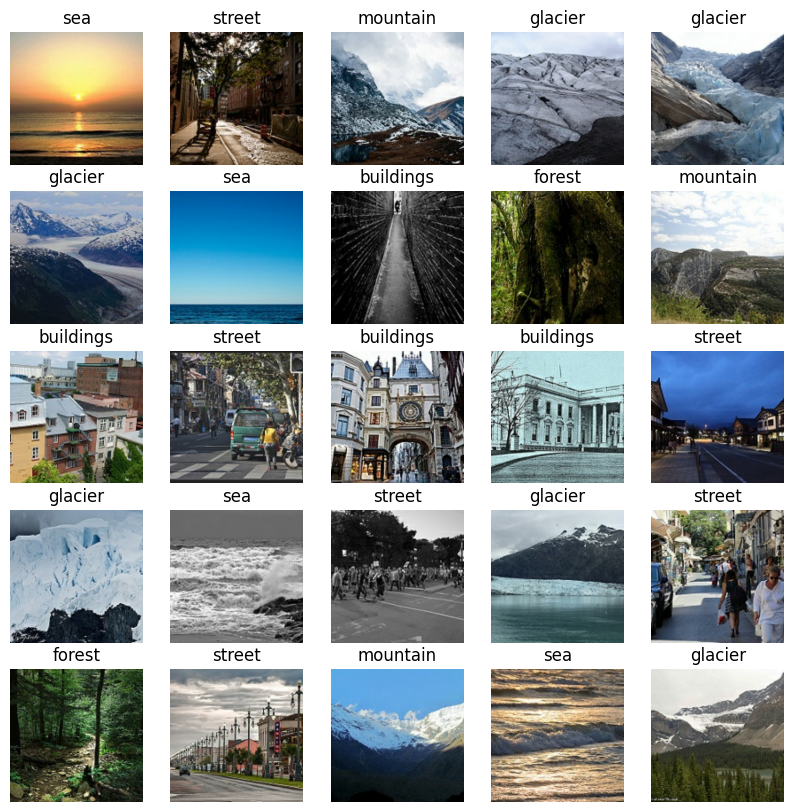

In [99]:
# Images from train dataset
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes_names[labels[i]])
        plt.axis('off')

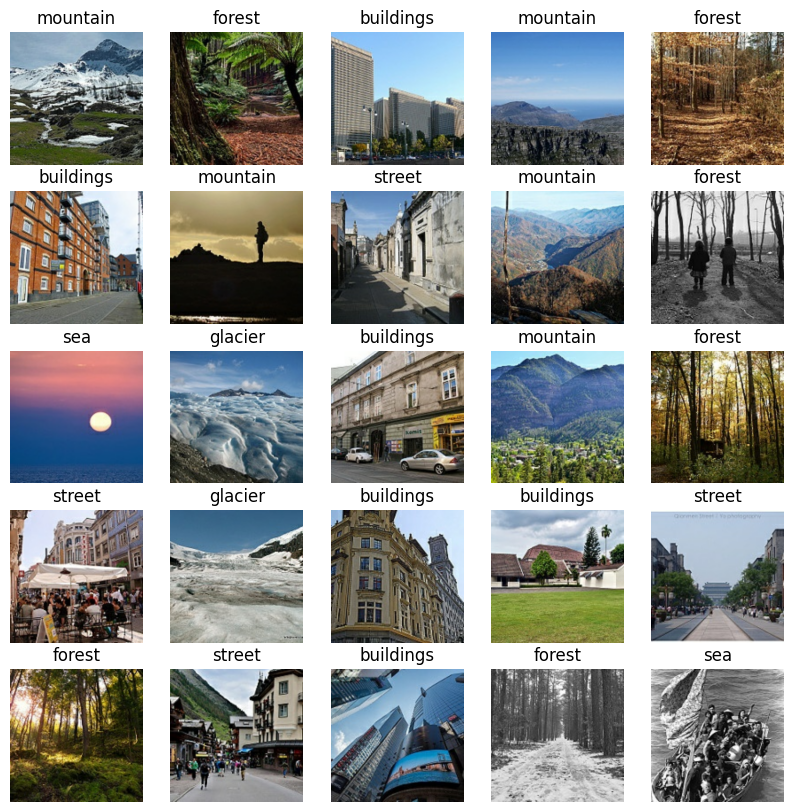

In [100]:
# Images from test dataset
plt.figure(figsize=(10,10))
for image,labels in test_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(classes_names[labels[i]])
        plt.axis('off')   

In [101]:
# Class counts for training dataset
class_counts = {}
for class_name in os.listdir(trainpath):
    class_dir = os.path.join(trainpath, class_name)  
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))  
        class_counts[class_name] = num_images  
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

buildings: 2191 images
forest: 2271 images
glacier: 2404 images
mountain: 2512 images
sea: 2274 images
street: 2382 images


In [102]:
# Class counts for testing dataset
class_counts = {}
for class_name in os.listdir(testpath):
    class_dir = os.path.join(testpath, class_name)  
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))  
        class_counts[class_name] = num_images  
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

buildings: 437 images
forest: 474 images
glacier: 553 images
mountain: 525 images
sea: 510 images
street: 501 images


In [103]:
# Nomalize the images by scaling their pixel values to the range [0, 1]
Norm_layer=tf.keras.layers.Rescaling(1/255)
train_ds=train_ds.map(lambda x , y :(Norm_layer(x),y))
test_ds=test_ds.map(lambda x , y :(Norm_layer(x),y))

## Build Mobel ##

In [109]:
# Create the model (Fixed model)
model = Sequential()
model.add(Input(shape=(288, 288, 3)))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))  # Reduce spatial dimensions further
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(classes_names), activation='softmax'))


In [110]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 284, 284, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 142, 142, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 138, 138, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 69, 69, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 67, 67, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 31, 31, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │    14,746,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,836,262 (56.60 MB)

 Trainable params: 14,836,262 (56.60 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [112]:
early_stopping=EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)

In [113]:
history = model.fit(train_ds, validation_data=test_ds, epochs=50, callbacks=[early_stopping])

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 190s 427ms/step - accuracy: 0.5106 - loss: 1.2428 - val_accuracy: 0.6760 - val_loss: 0.8597
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 181s 411ms/step - accuracy: 0.6834 - loss: 0.8224 - val_accuracy: 0.7413 - val_loss: 0.6969
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 179s 407ms/step - accuracy: 0.7514 - loss: 0.6718 - val_accuracy: 0.7597 - val_loss: 0.6413
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 175s 398ms/step - accuracy: 0.8022 - loss: 0.5353 - val_accuracy: 0.7750 - val_loss: 0.6233
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 180s 409ms/step - accuracy: 0.8516 - loss: 0.4126 - val_accuracy: 0.7687 - val_loss: 0.7191
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 182s 414ms/step - accuracy: 0.8916 - loss: 0.3055 - val_accuracy: 0.7690 - val_loss: 0.8083
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 182s 415ms/step - accuracy: 0.9237 - loss: 0.2141 - val_accuracy: 0.7770 - val_loss: 0.8881
Epoch 8/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 181s 412ms/step - accuracy: 0.9506 -

## Evaluate Model ##

In [116]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.7947 - loss: 1.2567
Test accuracy: 79.90%


In [115]:
loss, accuracy = model.evaluate(train_ds)
print(f'Train accuracy: {accuracy * 100:.2f}%')

439/439 ━━━━━━━━━━━━━━━━━━━━ 53s 121ms/step - accuracy: 0.9946 - loss: 0.0229
Train accuracy: 99.47%


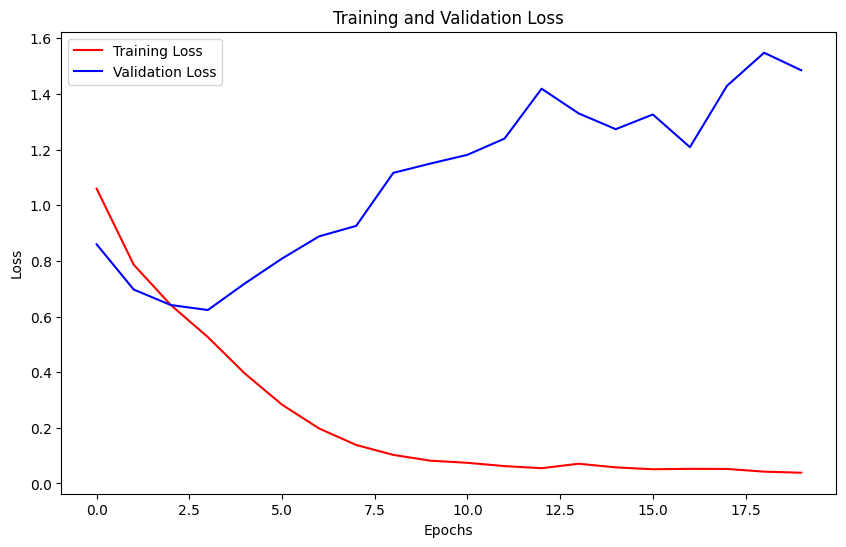

In [117]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, c="red", label="Training Loss")
plt.plot(epochs, val_loss, c="blue", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

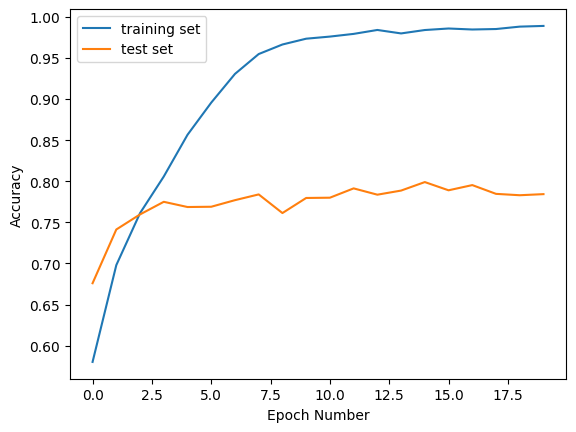

In [118]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

## Make Prediction ##

In [119]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_img(file_name, model):
	img = load_img(file_name, target_size=(288, 288))
	img_array = img_to_array(img)
	img_pro = np.expand_dims(img_array, axis=0)
	img_pro /= 255
	img_pred = model.predict(img_pro)
	index = np.argmax(img_pred)
	
	plt.title("Prediction - {}".format(str(classes_names[index]).title()), size=18, color='red')
	plt.imshow(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


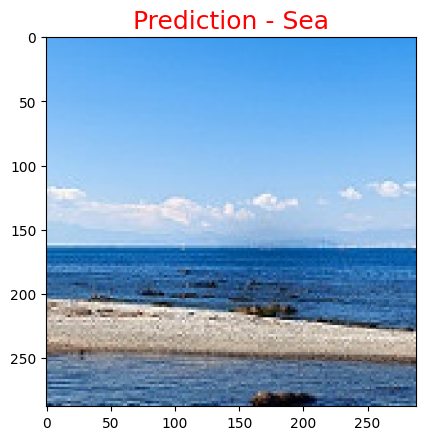

In [122]:
predict_img('Data/seg_pred/seg_pred/1003.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


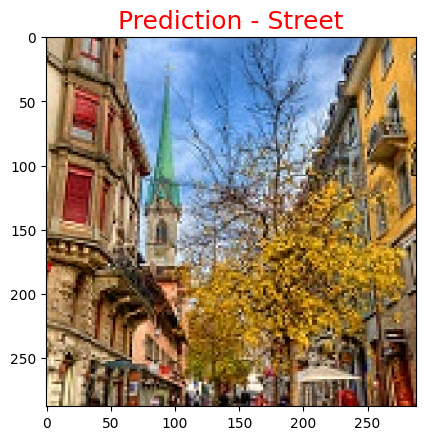

In [124]:
predict_img('Data/seg_pred/seg_pred/10004.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


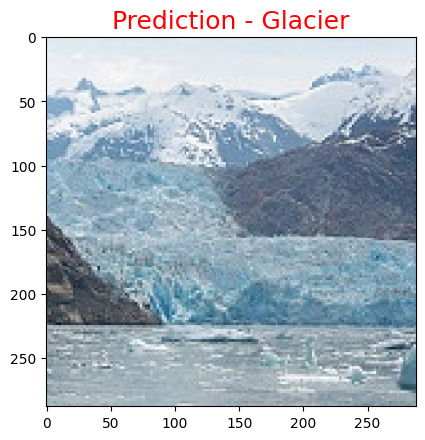

In [125]:
predict_img('Data/seg_pred/seg_pred/101.jpg', model)

### Visualize some misclassified images ###

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

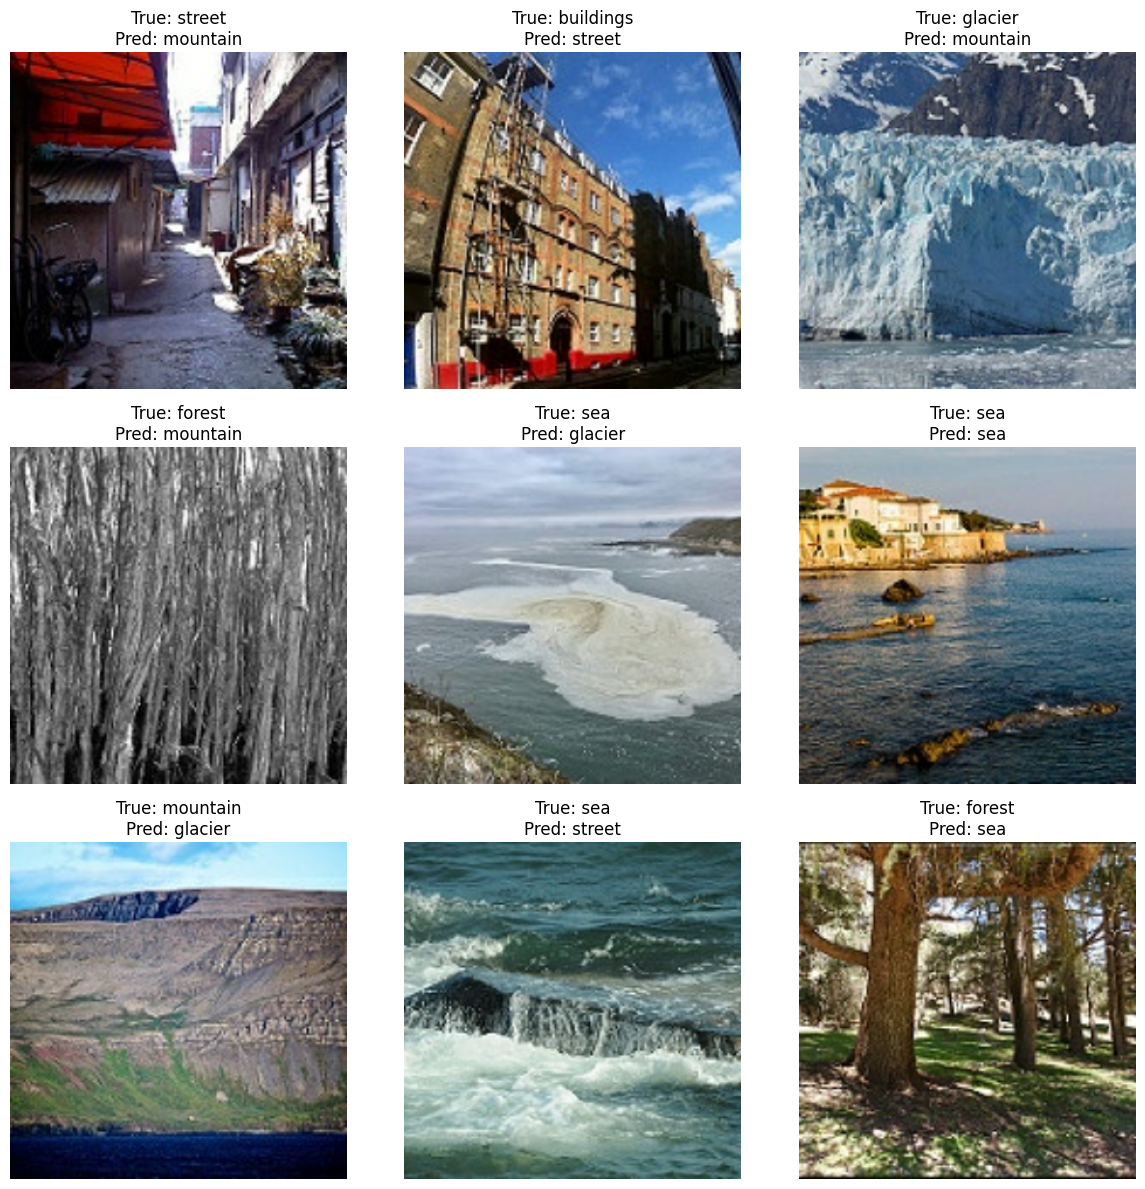

In [126]:
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred, target_names=classes_names)  
print(report)

misclassified_indices = np.where(y_true != y_pred)[0]

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

for i, (images, labels) in enumerate(test_ds):
    if i * BATCH_SIZE >= len(y_true): 
        break
    for j in range(len(images)):
        if len(misclassified_indices) == 0:
            break
        if (i * BATCH_SIZE + j) in misclassified_indices:
            misclassified_images.append(images[j].numpy())  
            misclassified_labels.append(classes_names[labels[j]])  
            misclassified_preds.append(classes_names[y_pred[i * BATCH_SIZE + j]]) 


plt.figure(figsize=(12, 12))
for i in range(min(9, len(misclassified_images))):  
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((misclassified_images[i] * 255).astype("uint8"))  
    plt.title(f"True: {misclassified_labels[i]}\nPred: {misclassified_preds[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()